<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Создание признаков</a></span></li><li><span><a href="#Разделение-датасета-на-выборки" data-toc-modified-id="Разделение-датасета-на-выборки-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Разделение датасета на выборки</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Обучение моделей</a></span></li><li><span><a href="#Вывод-по-разделу" data-toc-modified-id="Вывод-по-разделу-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Вывод по разделу</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

Задачи:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами.
4. Проверить данные на тестовой выборке и сделать выводы.

## Подготовка

In [1]:
# Импортируем нужные библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [2]:
# Задаем значения констант
dict_of_month = {
                    3: 'Март',
                    4: 'Апрель',
                    5: 'Май',
                    6: 'Июнь',
                    7: 'Июль',
                    8: 'Август'
                }

list_days = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']

MAX_LAG = 5

RANDOM_STATE = 42
TEST_SIZE = 0.1
cv = 3

In [3]:
# Функция для вывода графика количественных признаков
def graph_quant_feature(df, col_name, col_title):
    
    """
    Функция в качестве аргументов принимает датафрейм, название столбца, для которого необходимо вывести график, 
    и общее название для 2-х графиков. Она выводит гистограмму и диаграмму размаха для полученных данных
    """
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
    
    bins = int(np.log2(len(df[col_name])) + 1)
    
    sns.histplot(df[col_name], bins=bins, ax=axes[0], palette='deep', edgecolor='black')
    axes[0].set_xlabel('Число заказов такси')
    axes[0].set_ylabel('Количество наблюдений')
    axes[0].set_title('Гистограмма')
    axes[0].grid(True)
    
    sns.boxplot(x=df[col_name], orient='h', ax=axes[1], color='orange')
    axes[1].set_xlabel('Число заказов такси')
    axes[1].set_title('Диаграмма размаха')
    
    plt.suptitle(col_title)
    plt.show()
    
    print(f'Рассмотрим описательную статистику:\n{df[col_name].describe()}')

In [4]:
# Функция подбора гиперпараметров для модели 
def best_model_search(model, params, X, y, cv, grid_search=True, vb=0):
    
    """
    Выполняет подбор гиперпараметров для модели с использованием кросс-валидации.

    Parameters:
    ----------
    model : sklearn-модель
        Объект модели, для которой производится подбор гиперпараметров.
    params : dict
        Словарь с параметрами и их значениями для перебора.
    X : pandas.DataFrame или numpy.ndarray
        Признаки обучающей выборки.
    y : pandas.Series или numpy.ndarray
        Целевая переменная.
    randomized_search : bool, по умолчанию True
        Если True — используется GridSearchCV, иначе RandomizedSearchCV.
    cv : объект кросс-валидации (например, TimeSeriesSplit)
        Метод разбиения выборки на тренировочную и валидационную.
    vb : int, по умолчанию 0
        Уровень логирования (verbose) при обучении.

    Возвращает:
    -----------
    best_model : sklearn-модель
        Лучшая модель с оптимальными гиперпараметрами, обученная на всей выборке.
    
    Также добавляет в глобальный список `results` информацию о модели: 
    название, лучшие параметры, RMSE по кросс-валидации и время обучения.
    """
    
    if grid_search:
        grid = GridSearchCV(model,
                            params, 
                            scoring='neg_root_mean_squared_error',
                            cv=cv,
                            n_jobs=-1,
                            verbose=vb)
        
    else:   
        grid = RandomizedSearchCV(model,
                                  params, 
                                  scoring='neg_root_mean_squared_error',
                                  cv=cv,
                                  n_jobs=-1,
                                  verbose=vb,
                                  random_state=RANDOM_STATE)
        
    grid.fit(X, y)
      
    # Метрика и время лучшей модели
    best_model = grid.best_estimator_
    rmse_cv = -grid.best_score_
    mean_fit_time = grid.cv_results_['mean_fit_time'][grid.best_index_]
    mean_score_time = grid.cv_results_['mean_score_time'][grid.best_index_]
    
    results.append({
        'Model': grid.estimator.__class__.__name__,
        'Best Params': grid.best_params_,
        'Best RMSE (CV)': rmse_cv,
        'Mean Fit Time (s)': mean_fit_time,
        'Mean Score Time (s)': mean_score_time
    })
    
    return best_model

In [5]:
# Загружаем данные о заказах такси в аэропортах.
try:
    df = pd.read_csv('/datasets/taxi.csv')
    
except Exception as e:
    print(f"Произошла ошибка: {e}")

# Выводим первые 5 строк загруженных данных
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [6]:
# Выводим основную информацию по загруженным данным
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Названия столбцов соответствуют принятым стандартам, однако данные в столбце datetime следует привести к типу datetime для удобства обработки и анализа

In [7]:
# Преобразуем столбец 'datetime' в формат datetime
df['datetime'] = pd.to_datetime(df['datetime'])

In [8]:
# Находим временной интервал в данных
print('Начало:', df['datetime'].min(),
     '\nКонец:', df['datetime'].max())

Начало: 2018-03-01 00:00:00 
Конец: 2018-08-31 23:50:00


In [9]:
# Рассмотрим описательную статистику
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Число заказов такси за 10-минутный интервал варьируется от 0 до 119, в среднем составляя 14 заказов

In [10]:
# Найдем число полных дубликатов
df.duplicated().sum()

0

In [11]:
# Установим дату индексом датафрейма
df = df.set_index('datetime')

# Проверяем корректность преобразований
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [12]:
# Проверяем, в хронологическом ли порядке расположены даты и время
df.index.is_monotonic

True

In [13]:
# Выполним ресемплирование по каждому часу
resample_df = df.resample('1H').sum()
resample_df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [14]:
# Найдем число записией после ресемплирования
resample_df['num_orders'].count()

4416

**Вывод по разделу:**
- В исходных данных содержится 26496 записей о количестве заказов такси в аэропортах в различные временные промежутки.
- Данные охватывают период в 6 месяцев — с 1 марта по 31 августа 2018 года (с интервалом по 10 минут).
- Названия столбцов приведены в соответствие с общепринятыми стандартами.
- Признак времени был преобразован к типу datetime для удобства последующей работы с ним.
- Данные представлены в хронологическом порядке.
- После проведения ресемплирования в данных осталось 4416 записей.

## Анализ

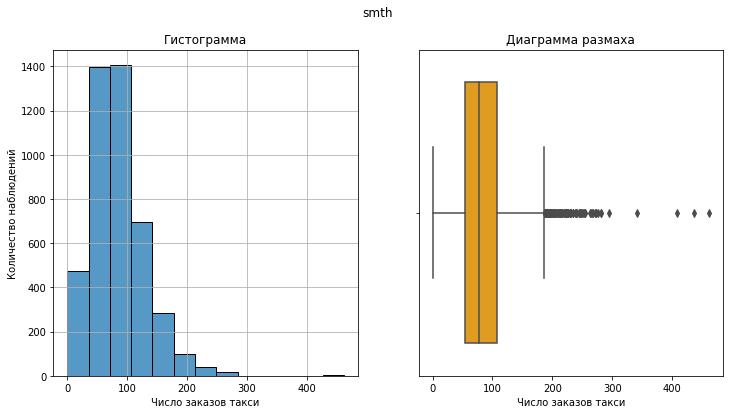

Рассмотрим описательную статистику:
count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64


In [15]:
# Рассмотрим распределение количества заказов за 1 час
graph_quant_feature(resample_df, 'num_orders', 'smth')

Большинство наблюдений показывают, что чаще всего в течение одного часа заказывают такси от 54 до 107 раз, в среднем - 84, а значения выше 200 можно считать аномальными

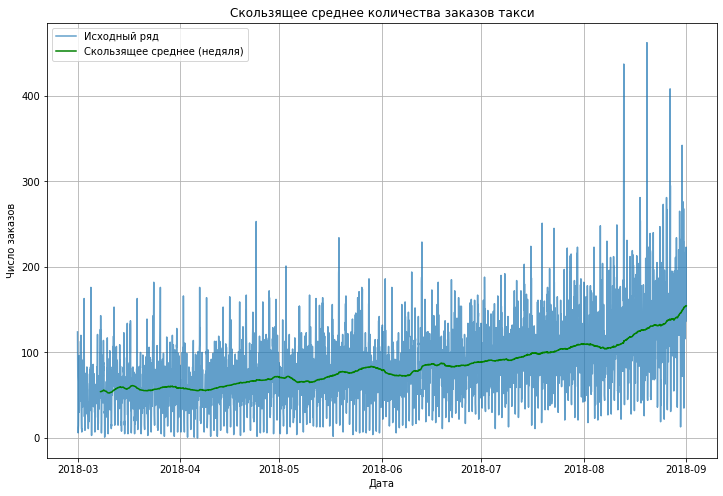

In [16]:
# Строим график скользящего среднего по неделям
resample_df['rolling_mean'] = resample_df['num_orders'].rolling(168).mean()

plt.figure(figsize=(12, 8))

plt.plot(resample_df['num_orders'], label='Исходный ряд', alpha=0.7)    
plt.plot(resample_df['rolling_mean'], label='Скользящее среднее (недяля)', color='green')

plt.title('Скользящее среднее количества заказов такси')
plt.xlabel('Дата')
plt.ylabel('Число заказов')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# Добавим номер месяца в датасет
resample_df['month'] = resample_df.index.month

# Проверяем корректность преобразований
resample_df.sample(5)

,num_orders,rolling_mean,month
datetime,,,
2018-06-11 13:00:00,68,78.148810,6
2018-06-24 06:00:00,29,84.523810,6
2018-06-17 21:00:00,83,85.309524,6
2018-05-20 11:00:00,51,77.333333,5
2018-07-20 18:00:00,108,100.375000,7


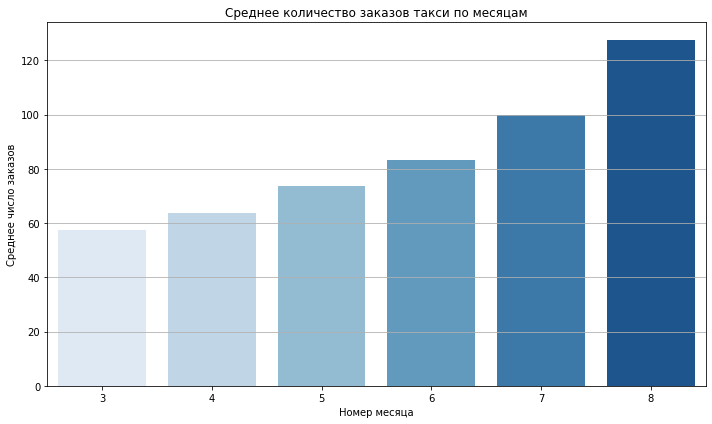

In [18]:
# Строим столбчатую диаграмму
plt.figure(figsize=(10, 6))

month_avg = resample_df.groupby('month')['num_orders'].mean().reset_index()

sns.barplot(data=month_avg, x='month', y='num_orders', palette='Blues')

plt.title('Среднее количество заказов такси по месяцам')
plt.xlabel('Номер месяца')
plt.ylabel('Среднее число заказов')
plt.xticks(rotation=0)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

На графиках заметна тенденция роста среднего количества заказов такси по мере приближения к концу анализируемого периода

Выявить полноценную сезонность не представляется возможным, поскольку данные охватывают лишь шестимесячный период в пределах одного года. Тем не менее, можно проанализировать тенденции внутри каждого месяца

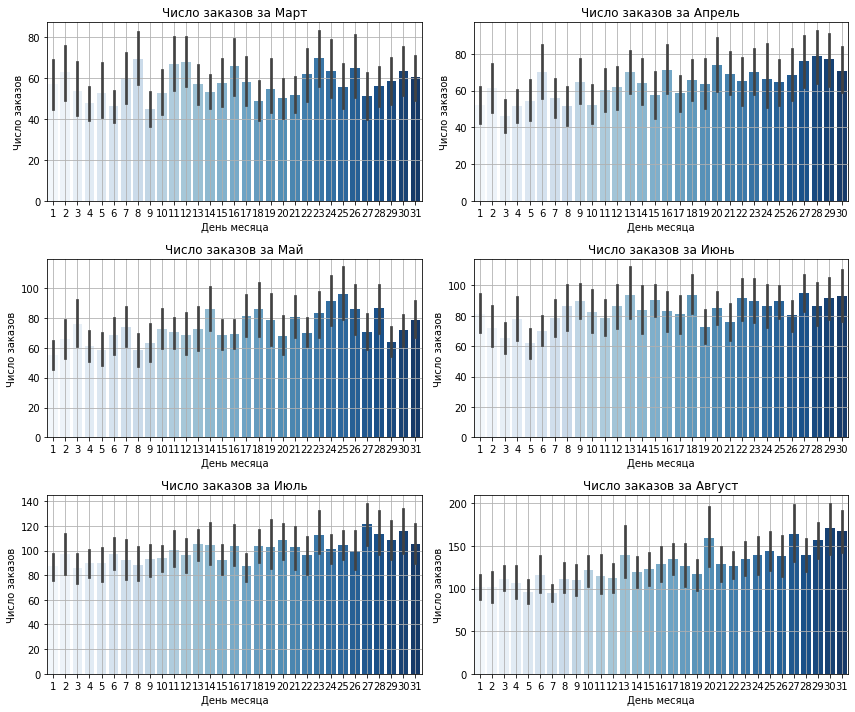

In [19]:
# Строим график столбчатой диаграммы для каждого месяца отдельно
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))
axes = axes.flatten()

for i, month in enumerate(range(3, 9)):
    
    month_data = resample_df[resample_df['month'] == month]
    
    sns.barplot(x=month_data.index.day, y=month_data['num_orders'], ax=axes[i], palette='Blues')
    
    axes[i].set_title(f'Число заказов за {dict_of_month[month]}')
    axes[i].set_xlabel('День месяца')
    axes[i].set_ylabel('Число заказов')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

Наблюдается снижение числа заказов примерно к 5-му дню месяца, за которым следует рост, обычно продолжающийся до конца месяца

In [20]:
# Добавим номер дня месяца и дня недели в датасет
resample_df['day_of_month'] = resample_df.index.day
resample_df['weekday'] = resample_df.index.weekday

# Проверяем корректность преобразований
resample_df.sample(5)

,num_orders,rolling_mean,month,day_of_month,weekday
datetime,,,,,
2018-06-25 09:00:00,101,85.005952,6,25,0
2018-08-17 23:00:00,155,124.803571,8,17,4
2018-07-19 23:00:00,152,99.869048,7,19,3
2018-06-03 14:00:00,68,74.726190,6,3,6
2018-05-10 06:00:00,18,65.226190,5,10,3


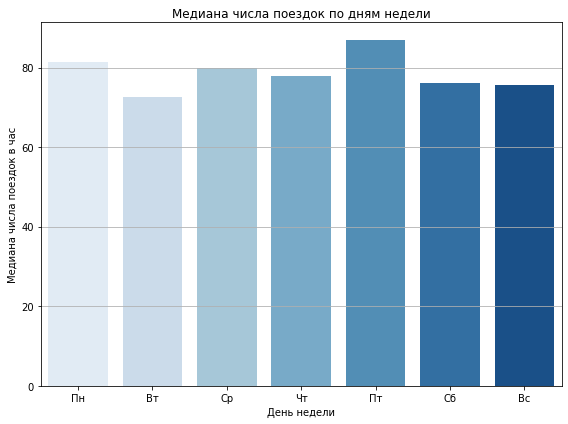

In [21]:
# Строим график медианного значения числа поездок по дням недели
median_by_weekday = resample_df.groupby('weekday')['num_orders'].median()

plt.figure(figsize=(8, 6))

sns.barplot(x=list_days, y=median_by_weekday, palette='Blues')

plt.title('Медиана числа поездок по дням недели')
plt.xlabel('День недели')
plt.ylabel('Медиана числа поездок в час')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

При сравнении медианного значения числа поездок самыми популярными днями недели являются пятница, понедельник и среда, а наименьшее количество заказов наблюдается во вторник, воскресенье и субботу

In [22]:
# Разложение временного ряда на тренд, сезонность и остаток
decomposed = seasonal_decompose(resample_df.iloc[:, :1])

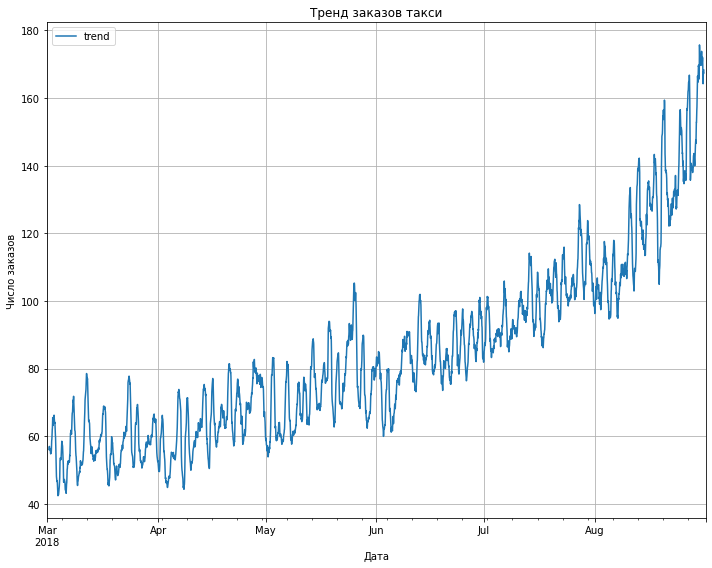

In [23]:
# Строим график тренда заказов такси
plt.figure(figsize=(10, 8))

decomposed.trend.plot()

plt.title('Тренд заказов такси')
plt.xlabel('Дата')
plt.ylabel('Число заказов')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

На графике наблюдается явный восходящий тренд на всем участке рассматриваемых данных, с резким ростом в августе

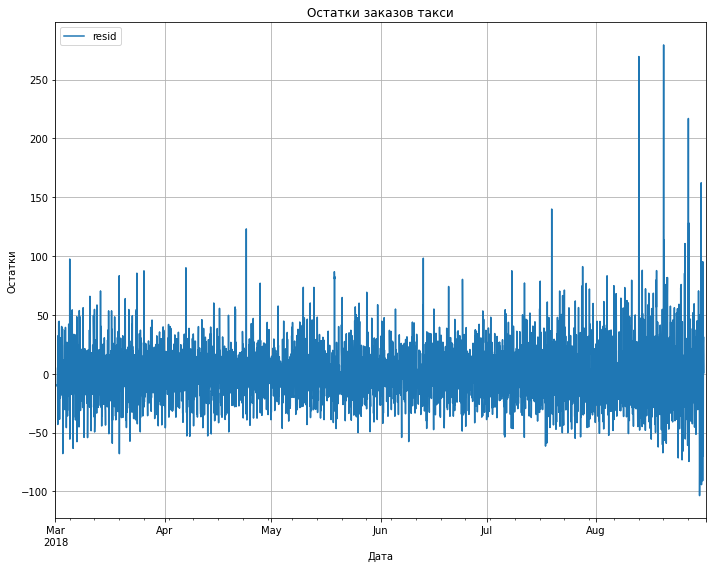

In [24]:
# Строим график остатков
plt.figure(figsize=(10, 8))

decomposed.resid.plot()

plt.title('Остатки заказов такси')
plt.xlabel('Дата')
plt.ylabel('Остатки')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

На графике остатков видны выбросы в августе, что может свидетельствовать о аномальных значениях числа заказов в этом месяце.

Исходя из личного опыта, добавим отдельную переменную — час дня, поскольку многие регулярные рейсы вылетают и прилетают в одно и то же время, что приводит к повышенному спросу на такси в эти часы

In [25]:
# Добавим час дня в датасет
resample_df['hour'] = resample_df.index.hour

# Проверяем корректность преобразований
resample_df.sample(3)

,num_orders,rolling_mean,month,day_of_month,weekday,hour
datetime,,,,,,
2018-03-07 02:00:00,24,NaN,3,7,2,2
2018-08-25 08:00:00,108,133.35119,8,25,5,8
2018-07-02 20:00:00,89,90.25000,7,2,0,20


Рассмотрим сезонность

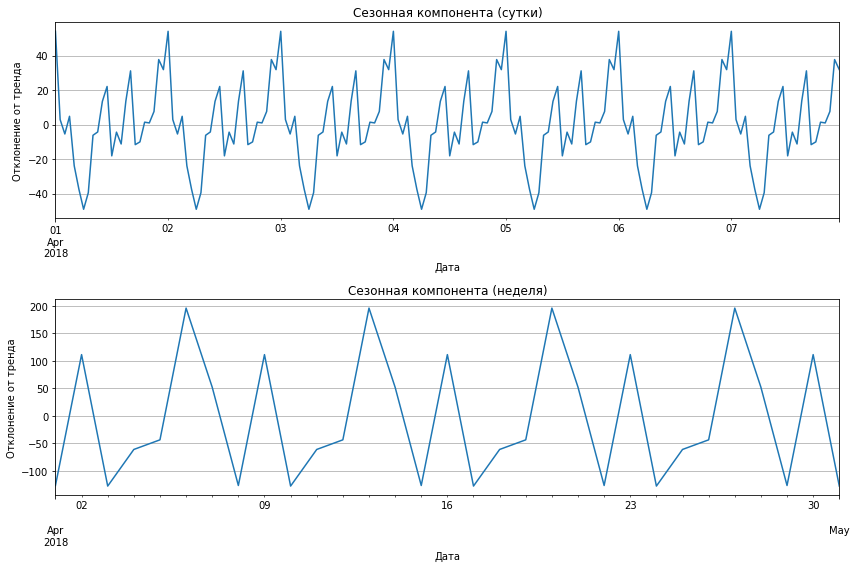

In [26]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

week_df = resample_df['num_orders']['2018-04-01' : '2018-04-07']
seasonal_decompose(week_df).seasonal.plot(ax=axes[0])
axes[0].set_xlabel('Дата')
axes[0].set_ylabel('Отклонение от тренда')
axes[0].set_title('Сезонная компонента (сутки)')
axes[0].grid(True)

month_df = resample_df['num_orders'].resample('1D').sum()['2018-04-01' : '2018-05-01']
seasonal_decompose(month_df).seasonal.plot(ax=axes[1])
axes[1].set_xlabel('Дата')
axes[1].set_ylabel('Отклонение от тренда')
axes[1].set_title('Сезонная компонента (неделя)')
axes[1].grid(True)

plt.tight_layout()
plt.show()

Из графиков можно сделать вывод, что спрос на такси значительно снижается ночью, что отражается в меньшем количестве заказов. С утра начинается рост заказов, который продолжается до вечера, достигая пика в районе полуночи. На графике, отображающем сезонность в течение недели, видно, что в понедельник и особенно в пятницу количество заказов достигает пиковых значений, в то время как во вторник наблюдается минимум.

**Вывод по разделу:**
- Число заказов такси в течение часа варьируется от 54 до 107, в среднем — 84. Значения выше 200 считаются аномальными.
- На графиках видно, что количество заказов растет в конце периода, с пиком в августе
- В течение месяца также наблюдается увеличение числа заказов такси ближе к концу месяца.
- Чаще всего заказы такси делают в пятницу, реже — во вторник.
- В датасет добавлены новые признаки: номер месяца (month), день месяца (day_of_month), день недели (weekday) и час дня (hour).

## Обучение

### Создание признаков

Изменим параметр скользящего среднего (rolling_mean), установив окно в 3 часа и исключив текущее значение из расчета

In [27]:
# Вносим изменения
resample_df['rolling_mean'] = resample_df['num_orders'].shift().rolling(3).mean()

# Проверяем корректность преобразований
resample_df.sample(3)

,num_orders,rolling_mean,month,day_of_month,weekday,hour
datetime,,,,,,
2018-07-02 10:00:00,133,73.000000,7,2,0,10
2018-07-06 18:00:00,122,104.333333,7,6,4,18
2018-03-18 17:00:00,40,59.666667,3,18,6,17


In [28]:
# Создаем отстающие признаки
for lag in range(1, MAX_LAG + 1):
    resample_df[f'lag_{lag}'] = resample_df['num_orders'].shift(lag) 
    
# Проверяем корректность преобразований
resample_df.head(7)

,num_orders,rolling_mean,month,day_of_month,weekday,hour,lag_1,lag_2,lag_3,lag_4,lag_5
datetime,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,3,1,3,0,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,3,1,3,1,124.0,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,3,1,3,2,85.0,124.0,NaN,NaN,NaN
2018-03-01 03:00:00,66,93.333333,3,1,3,3,71.0,85.0,124.0,NaN,NaN
2018-03-01 04:00:00,43,74.000000,3,1,3,4,66.0,71.0,85.0,124.0,NaN
2018-03-01 05:00:00,6,60.000000,3,1,3,5,43.0,66.0,71.0,85.0,124.0
2018-03-01 06:00:00,12,38.333333,3,1,3,6,6.0,43.0,66.0,71.0,85.0


In [29]:
# Удалим все запипси с пустыми значениями
resample_df.dropna(inplace=True)

# Проверяем корректность преобразований
resample_df.head()

,num_orders,rolling_mean,month,day_of_month,weekday,hour,lag_1,lag_2,lag_3,lag_4,lag_5
datetime,,,,,,,,,,,
2018-03-01 05:00:00,6,60.000000,3,1,3,5,43.0,66.0,71.0,85.0,124.0
2018-03-01 06:00:00,12,38.333333,3,1,3,6,6.0,43.0,66.0,71.0,85.0
2018-03-01 07:00:00,15,20.333333,3,1,3,7,12.0,6.0,43.0,66.0,71.0
2018-03-01 08:00:00,34,11.000000,3,1,3,8,15.0,12.0,6.0,43.0,66.0
2018-03-01 09:00:00,69,20.333333,3,1,3,9,34.0,15.0,12.0,6.0,43.0


### Разделение датасета на выборки

In [30]:
# Разделяем исходные данные на обучающую и тестовую выборки
X = resample_df.drop('num_orders', axis=1)
y = resample_df['num_orders']

cat_cols = resample_df.select_dtypes(include='int64').columns.tolist()[1:]
resample_df[cat_cols] = resample_df[cat_cols].astype('category')

num_cols = resample_df.select_dtypes(include='float64').columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(
                                                    X, 
                                                    y, 
                                                    test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE)

# Рассмотрим размеры сформированных выборок
X_train.shape, X_test.shape

((3969, 10), (442, 10))

Проверяем, что данные разделились правильно

In [31]:
# Последние 2 записи в тренировочной выборке
X_train[-2:].index.to_list()

[Timestamp('2018-08-13 12:00:00', freq='H'),
 Timestamp('2018-08-13 13:00:00', freq='H')]

In [32]:
# Первые 2 записи в тестовой выборке
X_test[:2].index.to_list()

[Timestamp('2018-08-13 14:00:00', freq='H'),
 Timestamp('2018-08-13 15:00:00', freq='H')]

Нет необходимости кодировать категориальные признаки, так как они уже представлены в виде порядковых номеров (месяц, день недели, час). Стандартизация количественных признаков также не является обязательной для используемых мной моделей

### Обучение моделей

In [33]:
# Создаем список для хранения результатов работы моделей
results = []

In [34]:
# Определяем TimeSeriesSplit для кросс-валидации с сохранением временного порядка
tscv = TimeSeriesSplit(n_splits=5)

С помощью функции best_model_search подбирается наилучшая модель и её параметры для решения задачи, с оценкой качества по метрике RMSE

In [35]:
# DecisionTree
tree_model = DecisionTreeRegressor(random_state=RANDOM_STATE)
tree_params = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}
best_tree = best_model_search(tree_model, tree_params, X_train, y_train, cv=tscv)

In [36]:
# RandomForest
model = RandomForestRegressor(random_state=RANDOM_STATE)
rf_params = {
    'n_estimators': [10, 20, 50],
    'max_depth': [3, 5, 7]
}

best_rf = best_model_search(model, rf_params, X_train, y_train, cv=tscv)

In [37]:
# LightGBM
lgb_model = LGBMRegressor(random_state=RANDOM_STATE)
lgb_params = {
    'n_estimators': [10, 50],
    'max_depth': [7, 10],
    'learning_rate': [0.01, 0.1]
}
best_lgb = best_model_search(lgb_model, lgb_params, X_train, y_train, cv=tscv)

In [38]:
# CatBoost
cat_model = CatBoostRegressor(verbose=0, random_state=RANDOM_STATE)
cat_params = {
    'iterations': [10, 50],
    'depth': [7, 10],
    'learning_rate': [0.01, 0.1]
}
best_cat = best_model_search(cat_model, cat_params, X_train, y_train, cv=tscv)

In [39]:
# Создаем DataFrame из результатов и сортируем по полученной метрике RMSE
results_df = pd.DataFrame(results).sort_values('Best RMSE (CV)')

pd.options.display.max_colwidth = 0

results_df

,Model,Best Params,Best RMSE (CV),Mean Fit Time (s),Mean Score Time (s)
2,LGBMRegressor,"{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50}",25.305540,0.339937,0.058926
3,CatBoostRegressor,"{'depth': 7, 'iterations': 50, 'learning_rate': 0.1}",26.613591,0.869719,0.001985
1,RandomForestRegressor,"{'max_depth': 7, 'n_estimators': 50}",27.079987,0.258221,0.008335
0,DecisionTreeRegressor,"{'max_depth': 7, 'min_samples_split': 10}",28.940416,0.008961,0.001805


Наилучшие результаты показала модель LGBMRegressor, которая и будет выбрана для проверки на тестовых данных

### Вывод по разделу

На данном этапе были сформированы вспомогательные признаки, направленные на улучшение предсказательной способности модели. Обучающая и тестовая выборки были подготовлены с учётом особенностей временных рядов. Для моделей машинного обучения был проведён подбор гиперпараметров и оценка качества с использованием метрики RMSE и кросс-валидации. По результатам сравнения была выбрана модель LightGBM, продемонстрировавшая лучшее качество.

## Тестирование

In [40]:
# Рассмотрим важность признаков
importances = pd.Series(best_lgb.feature_importances_,
                        index=X_train.columns)

importances.sort_values(ascending=False)

hour            484
month           138
lag_1           134
lag_4           116
lag_2           113
weekday         109
lag_5           106
rolling_mean    102
lag_3           102
day_of_month    86 
dtype: int32

Наибольшее влияние на число заказов оказывает час дня, что вполне логично, поскольку большинство рейсов прибывают и отправляются в одно и то же время, а значит, к этому времени наблюдается и повышенный спрос

In [41]:
# Оценка качества модели LightGBM на тестовой выборке
y_pred_lgb = best_lgb.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_lgb)).round(2)

print('RMSE LightGBM на тестовой выборке:', rmse_test)

RMSE LightGBM на тестовой выборке: 44.99


Значение RMSE на тестовой выборке значительно хуже, чем на тренировочной, но всё ещё соответствует условиям задачи (RMSE не превышает 48).

Рассмотрим на графике разницу между предсказанными и фактическими значениями

In [42]:
df_result = pd.DataFrame(y_test)
df_result['pred'] = y_pred_lgb.round(0)
df_result.columns = ['true', 'pred']

df_result.head()

,true,pred
datetime,,
2018-08-13 14:00:00,102,108.0
2018-08-13 15:00:00,175,116.0
2018-08-13 16:00:00,144,136.0
2018-08-13 17:00:00,152,138.0
2018-08-13 18:00:00,104,107.0


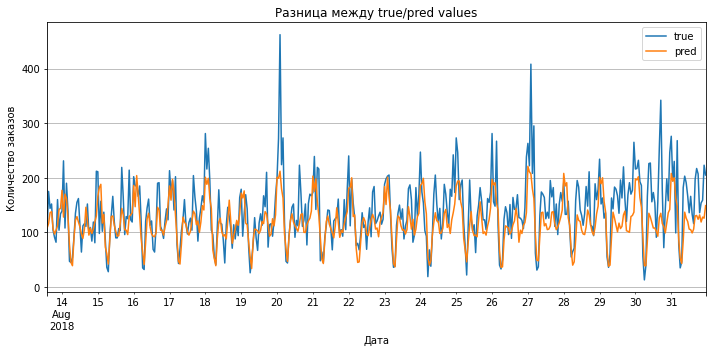

In [43]:
# Строим график разницы между предсказанными и фактическими значениями
df_result.resample('1H').sum().plot(figsize=(10, 5))

plt.title('Разница между true/pred values')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Как видно из графика, модель смогла подстроиться и предсказать типичные значения, однако для выбросов она дала неверные результаты

## Общий вывод

В данном исследовании была представлена информация о 26496 значениях количества заказов, разбитых на 10-минутные интервалы, охватывающих период в шесть месяцев — с 1 марта по 31 августа 2018 года. После ресемплирования с агрегированием по каждому часу в датасете осталось 4416 записей.

Анализ показал наличие восходящего тренда — количество заказов увеличивается ближе к концу рассматриваемого периода, достигая пика в августе. Наиболее часто заказы поступают по пятницам, а наименее активно — по вторникам. В течение часа количество заказов варьируется от 54 до 107, среднее значение составляет 84. Значения, превышающие 200, считаются аномальными.

Для повышения качества обучения моделей в данные были добавлены новые календарные признаки (номер месяца, день месяца, день недели, час дня), скользящее среднее, а также пять отстающих (лаговых) значений для каждой записи.

Обучающая и тестовая выборки были сформированы с учётом специфики временных рядов. Для моделей машинного обучения был проведён подбор гиперпараметров и оценка качества с использованием кросс-валидации и метрики RMSE. По итогам сравнительного анализа была выбрана модель LightGBM, показавшая лучшее качество. Наиболее важным признаком, влияющим на целевую переменную, оказался определённый час дня.

На тестовой выборке модель LightGBM достигла значения RMSE, равного 44.99. Она успешно воспроизвела типичные значения, однако на аномальных выбросах дала менее точные результаты.